In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv
/kaggle/input/glove840b300dtxt/glove.840B.300d.txt


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [4]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [5]:
train = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv')
validation = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')

In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
train.drop(['severe_toxic','obscene','threat','insult','identity_hate','id'],axis=1,inplace=True)


In [8]:
#after droping 
train.head()

,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [9]:
#checking the maximum number for doing the padding 
train['comment_text'].apply(lambda x:len(str(x).split())).max()

2321

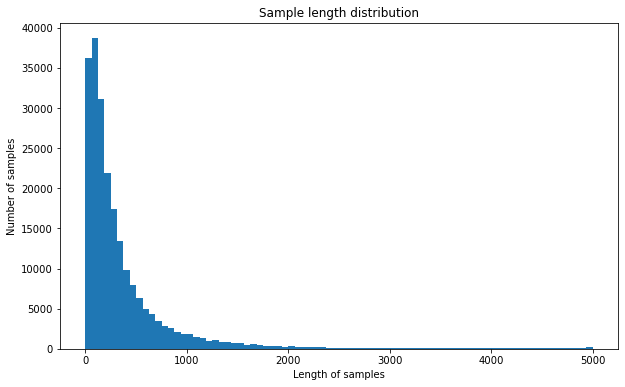

In [10]:
# Now, let's see the average number of words per sample
plt.figure(figsize=(10, 6))
plt.hist([len(sample) for sample in list(train['comment_text'])], 80)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

Data Preparation

In [11]:
#splitting the data into training set and validation set 
xtrain, xvalid, ytrain, yvalid = train_test_split(train.comment_text.values, train.toxic.values, 
                                                  stratify=train.toxic.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [12]:
texts = xtrain
words = [word for text in texts for word in text.split()]
v = sorted(list(set(words)))


In [13]:
from collections import Counter
word_counts = Counter(words)
print(word_counts.most_common(5))
v_s = sorted(word_counts.items(), key=lambda x: x[1],  reverse=True)
str2idx = {key:val for key,val in v_s}
idx2str = {val:key for key,val in v_s}
str2idx

[('the', 490536), ('to', 314627), ('of', 239588), ('and', 225215), ('a', 223080)]


{'the': 490536,
 'to': 314627,
 'of': 239588,
 'and': 225215,
 'a': 223080,
 'I': 193348,
 'is': 182762,
 'you': 166993,
 'that': 153785,
 'in': 143137,
 'for': 104012,
 'it': 101837,
 '"': 92063,
 'on': 91536,
 'not': 91350,
 'be': 88862,
 'this': 78111,
 'have': 74910,
 'as': 74364,
 'are': 72098,
 'with': 61847,
 'your': 58973,
 'was': 57959,
 'or': 52230,
 'but': 46992,
 'an': 45344,
 'The': 42764,
 'from': 42350,
 'article': 41742,
 'by': 41710,
 'at': 40461,
 'my': 39893,
 'about': 37980,
 'if': 34209,
 'do': 34107,
 'can': 33103,
 'has': 32357,
 'would': 31083,
 'will': 29995,
 'page': 29390,
 'like': 28002,
 'what': 27745,
 'so': 27486,
 'If': 27229,
 '==': 26912,
 'me': 26466,
 '-': 26434,
 'been': 26225,
 'just': 25783,
 'all': 25756,
 'they': 25536,
 'any': 25135,
 'should': 24858,
 'which': 24778,
 'one': 24693,
 'no': 23729,
 'more': 23418,
 'there': 23192,
 'You': 22937,
 'some': 22528,
 'other': 22468,
 "don't": 22183,
 'he': 22084,
 'who': 21257,
 'think': 20900,
 'we':

using RNN


In [51]:
token = text.Tokenizer(num_words=None)
max_len = 1000

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len,padding = 'post')
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len,padding = 'post')

word_index = token.word_index


In [52]:
len(word_index)

300257

In [53]:
%%time
with strategy.scope():
    # A simpleRNN without any pretrained embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index)+1,
                     300,
                     input_length=max_len))
    model.add(SimpleRNN(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()
    

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1000, 300)         90077400  
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 100)               40100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 90,117,601
Trainable params: 90,117,601
Non-trainable params: 0
_________________________________________________________________
CPU times: user 234 ms, sys: 46.3 ms, total: 280 ms
Wall time: 293 ms


In [54]:
history = model.fit(xtrain_pad, ytrain,  
                    epochs=5,
                    batch_size=64*strategy.num_replicas_in_sync,
                    validation_data=(xvalid_pad, yvalid))

Epoch 1/5
350/350 [==============================] - 32s 90ms/step - accuracy: 0.9044 - loss: 0.3176 - val_accuracy: 0.9045 - val_loss: 0.3159
Epoch 2/5
350/350 [==============================] - 28s 79ms/step - accuracy: 0.9039 - loss: 0.3166 - val_accuracy: 0.9044 - val_loss: 0.3168
Epoch 3/5
350/350 [==============================] - 28s 79ms/step - accuracy: 0.9046 - loss: 0.3154 - val_accuracy: 0.9045 - val_loss: 0.3151
Epoch 4/5
350/350 [==============================] - 28s 79ms/step - accuracy: 0.9046 - loss: 0.3153 - val_accuracy: 0.9045 - val_loss: 0.3153
Epoch 5/5
350/350 [==============================] - 28s 79ms/step - accuracy: 0.9046 - loss: 0.3153 - val_accuracy: 0.9045 - val_loss: 0.3158


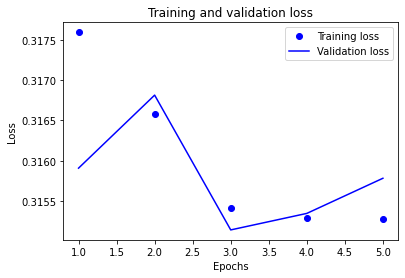

In [55]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Glove and  Lstm

In [56]:
#using pretraind Embedding
embeddings_index = {}
f = open('/kaggle/input/glove840b300dtxt/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

2196018it [05:13, 7013.25it/s]


In [57]:
print('Found %s word vectors.' % len(embeddings_index))

Found 2196017 word vectors.


In [58]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index)+1 , 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 300257/300257 [00:00<00:00, 306431.88it/s]


In [60]:
%%time
with strategy.scope():
    
    # A simple LSTM with glove embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index)+1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1000, 300)         90077400  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 90,237,901
Trainable params: 160,501
Non-trainable params: 90,077,400
_________________________________________________________________
CPU times: user 2.38 s, sys: 5.61 s, total: 7.99 s
Wall time: 11.6 s


In [61]:
history = model.fit(xtrain_pad, ytrain,  
                    epochs=5,
                    batch_size=64*strategy.num_replicas_in_sync,
                    validation_data=(xvalid_pad, yvalid))

Epoch 1/5
350/350 [==============================] - 35s 99ms/step - accuracy: 0.9046 - loss: 0.3266 - val_accuracy: 0.9044 - val_loss: 0.3156
Epoch 2/5
350/350 [==============================] - 30s 86ms/step - accuracy: 0.9045 - loss: 0.3154 - val_accuracy: 0.9045 - val_loss: 0.3151
Epoch 3/5
350/350 [==============================] - 30s 86ms/step - accuracy: 0.9046 - loss: 0.3151 - val_accuracy: 0.9045 - val_loss: 0.3160
Epoch 4/5
350/350 [==============================] - 30s 86ms/step - accuracy: 0.9047 - loss: 0.3148 - val_accuracy: 0.9044 - val_loss: 0.3158
Epoch 5/5
350/350 [==============================] - 30s 87ms/step - accuracy: 0.9048 - loss: 0.3148 - val_accuracy: 0.9045 - val_loss: 0.3154


In [63]:
%%time
with strategy.scope():
    # GRU with glove embeddings and two dense layers
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
     model.add(SpatialDropout1D(0.3))
     model.add(GRU(300))
     model.add(Dense(1, activation='sigmoid'))

     model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1000, 300)         90077400  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1000, 300)         0         
_________________________________________________________________
gru (GRU)                    (None, 300)               541800    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 301       
Total params: 90,619,501
Trainable params: 542,101
Non-trainable params: 90,077,400
_________________________________________________________________
CPU times: user 2.46 s, sys: 4.94 s, total: 7.4 s
Wall time: 10.9 s


In [67]:
history = model.fit(xtrain_pad, ytrain,  
                    epochs=8,
                    batch_size=128*strategy.num_replicas_in_sync,
                    validation_data=(xvalid_pad, yvalid))

Epoch 1/8
175/175 [==============================] - 30s 173ms/step - accuracy: 0.9045 - loss: 0.3151 - val_accuracy: 0.9044 - val_loss: 0.3157
Epoch 2/8
175/175 [==============================] - 20s 114ms/step - accuracy: 0.9046 - loss: 0.3151 - val_accuracy: 0.9045 - val_loss: 0.3155
Epoch 3/8
175/175 [==============================] - 20s 114ms/step - accuracy: 0.9045 - loss: 0.3151 - val_accuracy: 0.9045 - val_loss: 0.3152
Epoch 4/8
175/175 [==============================] - 21s 120ms/step - accuracy: 0.9046 - loss: 0.3151 - val_accuracy: 0.9045 - val_loss: 0.3160
Epoch 5/8
175/175 [==============================] - 20s 113ms/step - accuracy: 0.9046 - loss: 0.3154 - val_accuracy: 0.9044 - val_loss: 0.3155
Epoch 6/8
175/175 [==============================] - 20s 114ms/step - accuracy: 0.9046 - loss: 0.3151 - val_accuracy: 0.9045 - val_loss: 0.3164
Epoch 7/8
175/175 [==============================] - 20s 114ms/step - accuracy: 0.9046 - loss: 0.3151 - val_accuracy: 0.9045 - val_loss: